## Benchmarking

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from Benchmarking import *

In [3]:
def train(bases, smoothers, chm, gen_expts, datasets, model_root):

    for data_path in datasets:

        # data_path must end with generated_data
        data_path = data_path + "generated_data/"

        for gen_name in gen_expts:
            
            data_specs = "/".join(data_path.split("/")[-5:-2]) + "/chm{}/".format(chm)
            model_path = model_root + data_specs
            if not os.path.exists(model_path):
                os.makedirs(model_path)
                
            snp = data_path.split("/")[5]
            if snp == "full":
                M = 1000
            elif snp== "ukb":
                M = 30

            gens = gen_expts[gen_name]

            print("-"*100)
            print("Experiment details")
            print("Dataset used: {}".format(data_path))
            print("Generations used: {}".format(gens))
            print("Models will be stored at: {}".format(model_path))
            
            bm_train(bases, smoothers, model_path=model_path, data_path=data_path, gens=gens, chm=chm, M=M)

In [4]:
from Benchmarking import get_data, save_dict

def evaluate(bases, smoothers, chm, val_gens, data_path_fmt, model_path_fmt):

#     for set_name in ["full", "ukb"]:
    for set_name in ["full"]:
        M = 30 if set_name == "ukb" else 1000

#         for pop_name in ["latino","five","seven"]:
        for pop_name in ["seven"]:

            data_path = data_path_fmt.format(chm,set_name,pop_name)
            model_root = model_path_fmt.format(chm,set_name,pop_name)

            print("Getting traintime data for model meta data")
            train_data_root = "/home/arvindsk/xgmix_expts/benchmark_data/{0}/{1}/{2}/generated_data/"
            train_data_path = train_data_root.format(set_name,"bal_admix",pop_name)
            _, meta, _ = get_data(train_data_path, M=M, gens=[0,2], chm=chm, verbose=False)
            
            print("Getting validation set that was separately generated")
            print("Val generations: ",val_gens)
            val_paths = [data_path + "/chm{}/simulation_output/val/gen_".format(chm) + str(gen) + "/" for gen in val_gens] 
            X_val_files = [p + "mat_vcf_2d.npy" for p in val_paths]
            labels_val_files = [p + "mat_map.npy" for p in val_paths]
            train_val_files = [X_val_files, labels_val_files]
            X_val_raw, labels_val_raw = [load_np_data(f) for f in train_val_files]
            X_val, labels_window_val = data_process(X_val_raw, labels_val_raw, M, 0)
            X_v = np.array(X_val).astype("int8")
            y_v = np.array(labels_window_val).astype("int16")
            print(y_v.shape)
            y_snp = labels_val_raw.copy() # glue the old train data with the new val data

            for b in bases:
                
                base_path = model_root + "base_models/" + b + "_retrained.pkl"
                base = pickle.load(open(base_path,"rb"))
                B_v = base.predict_proba(X_v)

                for s in smoothers:

                    smooth_path = model_root + "smoothers/" + b + "_" + s + ".pkl"
                    metric_path = model_root + "/" + b + "_" + s + ".benchmark"
                    
                    print("Base:", base_path)
                    print("Smooth:", smooth_path)

                    model = Gnomix(C=meta["C"], M=meta["M"], A=meta["A"])
                    model.base = base
                    model.smooth = pickle.load(open(smooth_path,"rb"))

                    metrics = bm_eval(model, val_data=(X_v, y_v), gens=val_gens, y_snp=y_snp,
                                      base_smooth_paths=[base_path, smooth_path], B_v=B_v)
                    save_dict(metrics,metric_path)
                    

In [5]:
datasets_benchmark = [
# Full Genome
# "/home/arvindsk/xgmix_expts/benchmark_data/full/bal_admix/latino/",
# "/home/arvindsk/xgmix_expts/benchmark_data/full/bal_admix/five/",
"/home/arvindsk/xgmix_expts/benchmark_data/full/bal_admix/seven/",

# Array data
# "/home/arvindsk/xgmix_expts/benchmark_data/ukb/bal_admix/latino/",
# "/home/arvindsk/xgmix_expts/benchmark_data/ukb/bal_admix/five/",
# "/home/arvindsk/xgmix_expts/benchmark_data/ukb/bal_admix/seven/"
]

model_root = '/home/wknd37/gnomix/benchmark/models/'
# bases = ["lgb", "logreg", "randomstringkernel", "stringkernel"]
bases = ["lgb", "logreg", "randomstringkernel"]
smoothers = ["crf", "xgb", "cnn"]

chm = 20
gen_expts = {
    "all" : [0,2,4,8,16,24,32,48,64,72,100]
}

In [6]:
train(bases, smoothers, chm, gen_expts, datasets=datasets_benchmark, model_root=model_root)

----------------------------------------------------------------------------------------------------
Experiment details
Dataset used: /home/arvindsk/xgmix_expts/benchmark_data/full/bal_admix/seven/generated_data/
Generations used: [0, 2, 4, 8, 16, 24, 32, 48, 64, 72, 100]
Models will be stored at: /home/wknd37/gnomix/benchmark/models/full/bal_admix/seven/chm20/
Reading data...
Now training smoothers
Fetchinig base probabilites from lgb base
Training crf smoother
Training xgb smoother
Training cnn smoother
Fetchinig base probabilites from logreg base
Training crf smoother
Training xgb smoother
Training cnn smoother
Fetchinig base probabilites from randomstringkernel base
Training crf smoother
Training xgb smoother
Training cnn smoother


In [7]:
# function of chm, set_name, pop_name
model_path_fmt = "/home/wknd37/gnomix/benchmark/models/{1}/bal_admix/{2}/chm{0}/"
data_path_fmt = "/home/arvindsk/xgmix_expts/benchmark_data/val/chm{0}/{1}/{2}/generated_data/"
val_gens = [2,4,8,12,16,20,30,40,50,60,70,80,90,100]

In [8]:
evaluate(bases, smoothers, chm, val_gens=val_gens, data_path_fmt=data_path_fmt, model_path_fmt=model_path_fmt)

Getting traintime data for model meta data
Getting validation set that was separately generated
Val generations:  [2, 4, 8, 12, 16, 20, 30, 40, 50, 60, 70, 80, 90, 100]
(812, 516)
Base: /home/wknd37/gnomix/benchmark/models/full/bal_admix/seven/chm20/base_models/lgb_retrained.pkl
Smooth: /home/wknd37/gnomix/benchmark/models/full/bal_admix/seven/chm20/smoothers/lgb_crf.pkl
Base: /home/wknd37/gnomix/benchmark/models/full/bal_admix/seven/chm20/base_models/lgb_retrained.pkl
Smooth: /home/wknd37/gnomix/benchmark/models/full/bal_admix/seven/chm20/smoothers/lgb_xgb.pkl
Base: /home/wknd37/gnomix/benchmark/models/full/bal_admix/seven/chm20/base_models/lgb_retrained.pkl
Smooth: /home/wknd37/gnomix/benchmark/models/full/bal_admix/seven/chm20/smoothers/lgb_cnn.pkl
Base: /home/wknd37/gnomix/benchmark/models/full/bal_admix/seven/chm20/base_models/logreg_retrained.pkl
Smooth: /home/wknd37/gnomix/benchmark/models/full/bal_admix/seven/chm20/smoothers/logreg_crf.pkl
Base: /home/wknd37/gnomix/benchmark/mo

In [85]:
import pandas as pd

expt = ["model","base","smooth","pop_name","bal","snp"]
tuples = []
for set_name in ["full"]:
    for pop_name in ["seven"]:
        for base in ["lgb", "logreg", "randomstringkernel"]:
            for smooth in ["xgb", "crf", "cnn"]:
                for bal in ["bal_admix"]:
                    model_root = model_path_fmt.format(chm,set_name,pop_name)
                    metric_path = model_root + "/" + base + "_" + smooth + ".benchmark"
                    M = load_dict(metric_path)
                    skip_metrics = ["gen_performance"]
                    metric_names = [mkey for mkey in list(M.keys()) if mkey not in skip_metrics]
                    metrics = tuple([M[m] for m in metric_names])
                    tuples += [(base+"_"+smooth,base,smooth,pop_name,bal,set_name)+metrics]
                    
print(metric_names)
DF_us = pd.DataFrame(tuples, columns=expt+metric_names)
DF_us

['base_val_acc', 'base_val_acc_bal', 'base_val_log_loss', 'smooth_val_acc', 'smooth_val_acc_bal', 'smooth_val_log_loss', 'base_training_time', 'base_inference_time', 'smooth_training_time', 'smooth_inference_time', 'training_time', 'inference_time', 'model_total_size_mb', 'val_acc_snp_lvl']


,model,base,smooth,pop_name,bal,snp,base_val_acc,base_val_acc_bal,base_val_log_loss,smooth_val_acc,smooth_val_acc_bal,smooth_val_log_loss,base_training_time,base_inference_time,smooth_training_time,smooth_inference_time,training_time,inference_time,model_total_size_mb,val_acc_snp_lvl
0,lgb_xgb,lgb,xgb,seven,bal_admix,full,79.61,71.77,0.87,90.31,88.05,0.31,334.777997,1.637974,2705.593933,6.562170,3040.371930,8.200144,121.03,90.00
1,lgb_crf,lgb,crf,seven,bal_admix,full,79.61,71.77,0.87,90.39,88.41,0.30,334.777997,1.637974,98.944272,11.400925,433.722269,13.038900,120.21,90.09
2,lgb_cnn,lgb,cnn,seven,bal_admix,full,79.61,71.77,0.87,89.96,87.41,0.32,334.777997,1.637974,228.059222,0.174122,562.837219,1.812096,120.18,89.73
3,logreg_xgb,logreg,xgb,seven,bal_admix,full,87.42,81.35,0.45,93.75,91.33,0.20,2689.555401,2.208368,2569.386796,6.696969,5258.942198,8.905337,58.95,93.19
4,logreg_crf,logreg,crf,seven,bal_admix,full,87.42,81.35,0.45,93.68,91.57,0.20,2689.555401,2.208368,112.205862,11.402047,2801.761263,13.610414,58.14,93.12
5,logreg_cnn,logreg,cnn,seven,bal_admix,full,87.42,81.35,0.45,93.46,90.93,0.21,2689.555401,2.208368,218.785311,0.065996,2908.340712,2.274364,58.10,92.97
6,randomstringkernel_xgb,randomstringkernel,xgb,seven,bal_admix,full,88.15,78.00,0.37,93.73,90.93,0.20,77509.517382,28778.037553,2962.783075,5.978121,80472.300457,28784.015673,2420.26,93.35
7,randomstringkernel_crf,randomstringkernel,crf,seven,bal_admix,full,88.15,78.00,0.37,93.47,90.97,0.21,77509.517382,28778.037553,87.994040,11.588212,77597.511421,28789.625765,2419.43,93.09
8,randomstringkernel_cnn,randomstringkernel,cnn,seven,bal_admix,full,88.15,78.00,0.37,93.34,90.23,0.21,77509.517382,28778.037553,206.167384,0.064498,77715.684766,28778.102051,2419.41,93.02


In [86]:
M_rfmix = load_dict("/home/arvindsk/xgmix_expts/benchmark_data/rfmix/metrics.pkl")
chm = "20"
M_rfmix = M_rfmix[chm]

D = {
    "pop_name": [] ,"snp": [],
    "training_time": [], "inference_time": [],
    "val_acc": [], "val_acc_snp_lvl": []
}
for m in list(M_rfmix.keys()):
    snp, pop_name = m.split("_")
    training_time = M_rfmix[m]["runtime"]
    val_acc = M_rfmix[m]["val_acc"]
    D["model"] = "rfmix"
    D["snp"].append(snp)
    D["pop_name"].append(pop_name)
    D["training_time"].append(training_time)
    D["inference_time"].append(training_time)    
    D["val_acc"].append(val_acc)
    D["val_acc_snp_lvl"].append(val_acc)
DF_rfmix = pd.DataFrame(D)
DF_rfmix

,pop_name,snp,training_time,inference_time,val_acc,val_acc_snp_lvl,model
0,latino,ukb,82.475601,82.475601,95.58,95.58,rfmix
1,five,ukb,196.271353,196.271353,90.28,90.28,rfmix
2,seven,ukb,241.045573,241.045573,84.81,84.81,rfmix
3,latino,full,1594.307887,1594.307887,95.94,95.94,rfmix
4,five,full,4260.723067,4260.723067,90.76,90.76,rfmix
5,seven,full,5518.312196,5518.312196,88.18,88.18,rfmix


In [87]:
DF_elai = pd.DataFrame({
    "model": ["elai"]*2,
    "val_acc_snp_lvl": [88.32, 92.34],
    "training_time": [37219., 334003.],
    "inference_time": [37219., 334003.],
    "pop_name": ["seven"]*2,
    "snp": ["ukb", "full"]
})
DF_elai

,model,val_acc_snp_lvl,training_time,inference_time,pop_name,snp
0,elai,88.32,37219.0,37219.0,seven,ukb
1,elai,92.34,334003.0,334003.0,seven,full


In [88]:
DF = DF_us.append(DF_rfmix)
DF = DF.append(DF_elai)
DF["dataset"] = DF.apply(lambda row: row.pop_name + "-" + row.snp, axis=1)
DF

,model,base,smooth,pop_name,bal,snp,base_val_acc,base_val_acc_bal,base_val_log_loss,smooth_val_acc,...,base_training_time,base_inference_time,smooth_training_time,smooth_inference_time,training_time,inference_time,model_total_size_mb,val_acc_snp_lvl,val_acc,dataset
0,lgb_xgb,lgb,xgb,seven,bal_admix,full,79.61,71.77,0.87,90.31,...,334.777997,1.637974,2705.593933,6.562170,3040.371930,8.200144,121.03,90.00,NaN,seven-full
1,lgb_crf,lgb,crf,seven,bal_admix,full,79.61,71.77,0.87,90.39,...,334.777997,1.637974,98.944272,11.400925,433.722269,13.038900,120.21,90.09,NaN,seven-full
2,lgb_cnn,lgb,cnn,seven,bal_admix,full,79.61,71.77,0.87,89.96,...,334.777997,1.637974,228.059222,0.174122,562.837219,1.812096,120.18,89.73,NaN,seven-full
3,logreg_xgb,logreg,xgb,seven,bal_admix,full,87.42,81.35,0.45,93.75,...,2689.555401,2.208368,2569.386796,6.696969,5258.942198,8.905337,58.95,93.19,NaN,seven-full
4,logreg_crf,logreg,crf,seven,bal_admix,full,87.42,81.35,0.45,93.68,...,2689.555401,2.208368,112.205862,11.402047,2801.761263,13.610414,58.14,93.12,NaN,seven-full
5,logreg_cnn,logreg,cnn,seven,bal_admix,full,87.42,81.35,0.45,93.46,...,2689.555401,2.208368,218.785311,0.065996,2908.340712,2.274364,58.10,92.97,NaN,seven-full
6,randomstringkernel_xgb,randomstringkernel,xgb,seven,bal_admix,full,88.15,78.00,0.37,93.73,...,77509.517382,28778.037553,2962.783075,5.978121,80472.300457,28784.015673,2420.26,93.35,NaN,seven-full
7,randomstringkernel_crf,randomstringkernel,crf,seven,bal_admix,full,88.15,78.00,0.37,93.47,...,77509.517382,28778.037553,87.994040,11.588212,77597.511421,28789.625765,2419.43,93.09,NaN,seven-full
8,randomstringkernel_cnn,randomstringkernel,cnn,seven,bal_admix,full,88.15,78.00,0.37,93.34,...,77509.517382,28778.037553,206.167384,0.064498,77715.684766,28778.102051,2419.41,93.02,NaN,seven-full
0,rfmix,NaN,NaN,latino,NaN,ukb,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,82.475601,82.475601,NaN,95.58,95.58,latino-ukb


In [93]:
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
import matplotlib as mpl
import matplotlib.patches as mpatches

def barplot_metric_vs_data(DF, metrics, bal="bal_admix", rfmix_line=False, dataset=None, 
                           metr_labls=None, log_metrics=None, y_lims=None, fz=22, figsize = [8, 6],
                           rot="90", right_legend=True, n_models=11):

    DF = DF.copy()
    fig, ax = plt.subplots(1, len(metrics), figsize=figsize)
    
    if n_models == 14:
        colors = [s+c for c in ["blue", "green", "orange", "red"] for s in ["dark", "", "light"]]
        colors[1] = "royalblue"; colors[5] = "limegreen"
        colors[10] = "coral"; colors[11] = "lightcoral"; colors[8] = "yellow"
        colors += ["black", "gray"]
    
    if n_models == 11:
        colors = [s+c for c in ["blue", "green", "orange"] for s in ["dark", "", "light"]]
        colors[1] = "royalblue"; colors[5] = "limegreen"
    #     colors[10] = "coral"; colors[11] = "lightcoral"; 
        colors[8] = "yellow"
        colors += ["black", "gray"]

    if fz is not None:
        mpl.rcParams['xtick.labelsize'] = fz 
        mpl.rcParams['ytick.labelsize'] = fz 
        mpl.rcParams['legend.fontsize'] = fz
    
    for i, metric in enumerate(metrics):
        
        log_metric = False if log_metrics is None else log_metrics[i]
        metr_labl = metr_labls[i] if metr_labls is not None else metrics[i]
    
        if dataset is None:    
            datasetorder = CategoricalDtype(
                ['latino-full', 'latino-ukb', 'five-full', 'five-ukb', 'seven-full', 'seven-ukb'],
                ordered=True
            )
            DF["dataset"] = DF["dataset"].astype(datasetorder)
            DF = DF.sort_values(by=['dataset'])
        else:
            DF = DF[DF.dataset == dataset]

        df = DF[( (DF.bal == bal) | (DF.bal.isnull()) )]

        # rfmix
        if rfmix_line:
            df_rfmix = df[df.model == "rfmix"].copy()
            df_rfmix.plot(y=metric, x="dataset", ax=ax[i], c="gray", label="rfmix")
            df = df[df.model != "rfmix"]

        if dataset is None:
            df = df[[metric, "model", "dataset"]]
            df = df.pivot(index="dataset", columns='model', values=metric)
            df.plot.bar(ax=ax[i])
        else:
            metric_model = list(zip(df[metric], df.model, colors[-len(df.model):]))
            sortd = sorted(metric_model, key = lambda x:x[0])
            metr, mdl, cols = list(zip(*sortd))
            ax[i].bar(x=mdl, height=metr, color=cols)
            if log_metric:
                ax[i].set_yscale("log")

        if y_lims is not None:
            ax[i].set_ylim(y_lims[i])
        ax[i].set_ylabel(metr_labl, fontsize=fz)
        # ax[i].set_xlabel("model", fontsize=fz)
        ax[i].set_xticks([])
        for tick in ax[i].get_xticklabels():
            tick.set_rotation(rot)
            

    print("data:", dataset)
    fig.tight_layout(pad=2.0)    

    if right_legend:
        patches = []
        for i, color in enumerate(colors[-len(df.model):]):
            model_string = list(df.model)[i].replace("_","-").replace("randomstringkernel", "rsk")
            patches.append(mpatches.Patch(color=color, label=model_string))
        ax[-1].legend(handles=patches, bbox_to_anchor=(1.25, 1.1), loc='upper left')

        plt.show()

data: seven-ukb


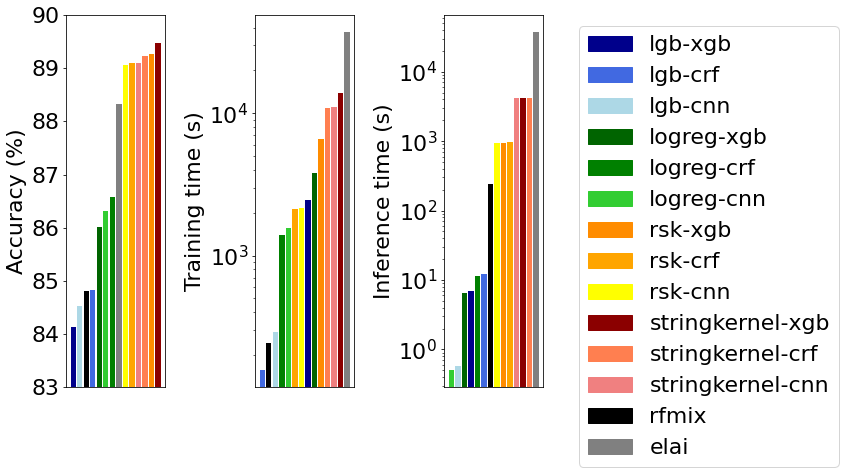

In [79]:
barplot_metric_vs_data(
    DF, dataset="seven-ukb",
    metrics = ["val_acc_snp_lvl", "training_time", "inference_time"],
    metr_labls = ["Accuracy (%)", "Training time (s)" , "Inference time (s)"],
    y_lims = ((83,90), None, None),
    log_metrics = (False, True, True)
)

data: seven-full


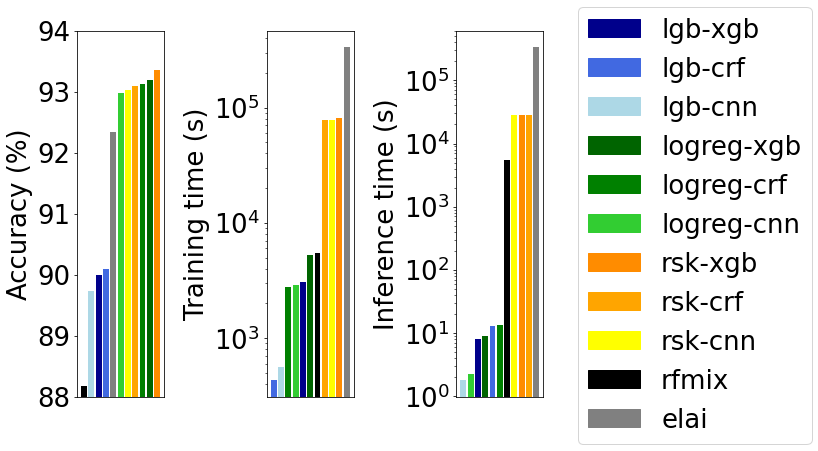

In [94]:
barplot_metric_vs_data(
    DF, dataset="seven-full",
    metrics = ["val_acc_snp_lvl", "training_time", "inference_time"],
    metr_labls = ["Accuracy (%)", "Training time (s)" , "Inference time (s)"],
    y_lims = ((88,94), None, None),
    log_metrics = (False, True, True),
    fz = 26
)

In [154]:
def plot_acc_vs_gen(chm, set_name, pop_name, bal, base, smooth, df_elai=None, title=False, fz=None, figsize=None):
    
    mpl.rcParams.update(mpl.rcParamsDefault)
    if fz is not None:
        fig, ax = plt.subplots(figsize=figsize)
        mpl.rcParams['xtick.labelsize'] = fz 
        mpl.rcParams['ytick.labelsize'] = fz 
        mpl.rcParams['legend.fontsize'] = 18
        mpl.rcParams['legend.title_fontsize'] = 18
        plt.xticks(fontsize=fz)
        plt.yticks(fontsize=fz)

    
    cmap = { 0:'darkgreen', 1:'tab:blue',  2:'y', 3:'g'}
    lmap = { 0:'-', 1:'--', 2:':', 3:'-.' }
    acc_str = lambda acc: " (" + str(acc) + "%)"
    
    for i, b in enumerate(base):
        for j, s in enumerate(smooth):
            model_root = model_path_fmt.format(chm,set_name,pop_name)
            metric_path = model_root + "/" + b + "_" + s + ".benchmark"
            M = load_dict(metric_path)
            val_acc = M["smooth_val_acc"]
            m_name = b + "_" + s
            G = M["gen_performance"]
            plt.plot(G["gens"], G["accs_snp_lvl"], linestyle=lmap[i%len(lmap)], color=cmap[j%len(cmap)],
                             label= m_name) # + acc_str(val_acc))

    # RFmix
    M_gen_rfmix_raw = load_dict("/home/arvindsk/xgmix_expts/benchmark_data/rfmix/metrics_gen_wise.pkl")
    G_rfmix = M_gen_rfmix_raw[chm][set_name+"_"+pop_name]
    plt.plot(G["gens"], G_rfmix["genwise_val_acc"], linestyle="--", color="k",
                     label= "rfmix")# + acc_str(G_rfmix["val_acc"]))
    
    data = "ancestry:" + pop_name + ", snps:" +set_name
    print(data)
    plt.legend(title="model") # (average accuracy)")
    plt.xlabel("Generation", fontsize=fz)
    plt.ylabel("Accuracy (%)", fontsize=fz)
    plt.show()

ancestry:seven, snps:ukb


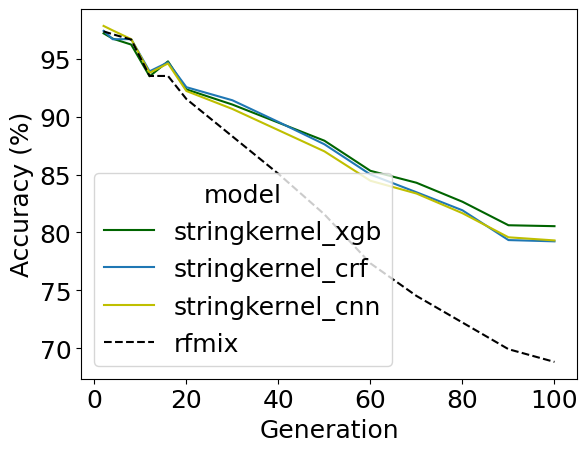

In [155]:
chm = "20"
pop_name = "seven" 
bal = "bal_admix"
base = ["stringkernel"]
smooth = ["xgb", "crf", "cnn"]

plot_acc_vs_gen(chm, "ukb", pop_name, bal, base, smooth, fz=18)

ancestry:seven, snps:full


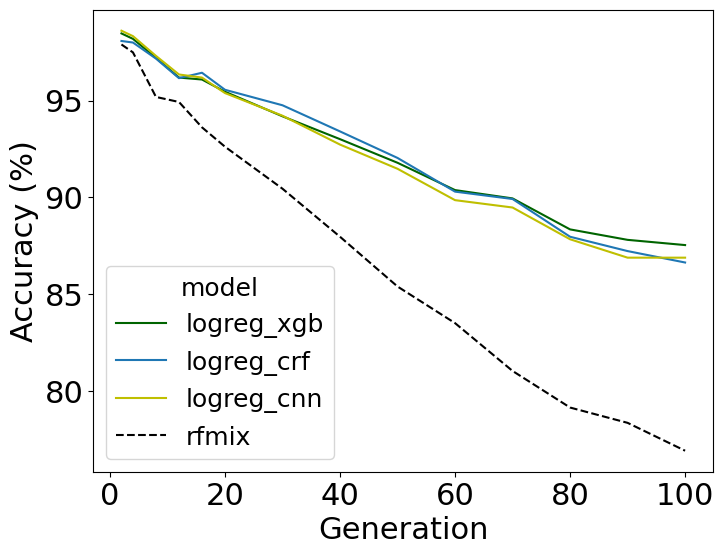

In [156]:
base = ["logreg"]
plot_acc_vs_gen(chm, "full", pop_name, bal, base, smooth, fz=22, figsize=(8,6))